# Inclusion Stress Field Prediction

Импортируем библиотеки:

In [1]:
import os
import glob

import cv2

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms, models
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

import albumentations as A

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
torch.manual_seed(42)
cudnn.deterministic = True
cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Обозначим константы:

In [2]:
#Model Constants
IMAGE_SIZE = 256
BATCH_SIZE = 5
LAMBDA_L1 = 100
LEARNING_RATE = 1e-3
EPOCH = 300
COMPONENTS = ['s11', 's12', 's22', 'e11', 'e12', 'e22']
CURRENT_ELEMENT = 's11'

Основные пути к папкам, откуда мы будем брать исходные данные для данного проекта:

In [3]:
path_folder = 'S:/abaqus_job_files/plot\\'
path_table = 'S:/abaqus_job_files/stresses_data/general_array.csv'
path_model_save = 'S:/abaqus_job_files/models/'

## Работа с табличными данными

In [4]:
def data_preparation(path, path_csv):
    
    stress_components = COMPONENTS + ['geom']
    
    #read data
    df = pd.read_csv(path_csv, delimiter=' ', header=0).round(2)
    df.index += 1
    
    for i in stress_components:

        raw_images = sorted(glob.glob(path + '/*' + i + '*'), key=len)
        df['images_' + i] = raw_images
    
    df = df.dropna(axis=1)
    df_train, df_valid = train_test_split(df,
                                          train_size=.8,
                                          random_state=42,
                                          shuffle=True)
    
    print(f'Train shape: {df_train.shape[0]}')
    print(f'Valid shape: {df_valid.shape[0]}')
        
    return df_train, df_valid

Разделим данные на тренировочную, валидационную и тестовую выборки.

In [5]:
df_train, df_valid = data_preparation(path_folder, path_table)

Train shape: 800
Valid shape: 200


In [6]:
df_train.head()

,max_s11,min_s11,max_s22,min_s22,max_s12,min_s12,max_e11,min_e11,max_e22,min_e22,max_e12,min_e12,images_s11,images_s12,images_s22,images_e11,images_e12,images_e22,images_geom
30,132.94,73.19,138.69,74.48,28.44,-28.08,0.90,0.07,0.90,0.08,0.84,-0.83,S:/abaqus_job_files/plot\30_s11.png,S:/abaqus_job_files/plot\30_s12.png,S:/abaqus_job_files/plot\30_s22.png,S:/abaqus_job_files/plot\30_e11.png,S:/abaqus_job_files/plot\30_e12.png,S:/abaqus_job_files/plot\30_e22.png,S:/abaqus_job_files/plot\30_geom.png
536,137.55,73.90,135.18,72.72,31.46,-26.36,0.90,0.08,0.90,0.07,0.93,-0.78,S:/abaqus_job_files/plot\536_s11.png,S:/abaqus_job_files/plot\536_s12.png,S:/abaqus_job_files/plot\536_s22.png,S:/abaqus_job_files/plot\536_e11.png,S:/abaqus_job_files/plot\536_e12.png,S:/abaqus_job_files/plot\536_e22.png,S:/abaqus_job_files/plot\536_geom.png
696,135.01,71.66,137.36,71.48,27.84,-25.42,0.95,0.07,1.00,0.07,0.82,-0.75,S:/abaqus_job_files/plot\696_s11.png,S:/abaqus_job_files/plot\696_s12.png,S:/abaqus_job_files/plot\696_s22.png,S:/abaqus_job_files/plot\696_e11.png,S:/abaqus_job_files/plot\696_e12.png,S:/abaqus_job_files/plot\696_e22.png,S:/abaqus_job_files/plot\696_geom.png
558,153.44,71.42,178.36,70.31,28.67,-47.23,1.01,0.04,1.14,0.07,0.84,-1.39,S:/abaqus_job_files/plot\558_s11.png,S:/abaqus_job_files/plot\558_s12.png,S:/abaqus_job_files/plot\558_s22.png,S:/abaqus_job_files/plot\558_e11.png,S:/abaqus_job_files/plot\558_e12.png,S:/abaqus_job_files/plot\558_e22.png,S:/abaqus_job_files/plot\558_geom.png
837,174.53,72.12,151.62,74.04,30.21,-40.91,1.20,0.03,1.12,0.05,0.89,-1.20,S:/abaqus_job_files/plot\837_s11.png,S:/abaqus_job_files/plot\837_s12.png,S:/abaqus_job_files/plot\837_s22.png,S:/abaqus_job_files/plot\837_e11.png,S:/abaqus_job_files/plot\837_e12.png,S:/abaqus_job_files/plot\837_e22.png,S:/abaqus_job_files/plot\837_geom.png


## EDA

Оценим распределение представленных величин.

In [7]:
def kde_plot(data_list, columns, variable_name):
    
    fig, ax = plt.subplots(2, 3, figsize=(13, 9))
    
    for data in data_list:
        for column, i, j in zip(columns, [0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]):
            
            sns.kdeplot(x=column,
                        data=data,
                        shade=True,
                        ax=ax[i, j])
            
            if j == 0:
                ax[i, j].set_ylabel('Density', fontsize=12)
            else:
                ax[i, j].set_ylabel('')
                
            ax[i, j].set_xlabel(f'{column}')
            ax[i, j].set_title(f'KDE of {column}')
            ax[i, j].legend(['Train', 'Valid', 'Test'])
    
    fig.suptitle(f'Kernel density estimation of presented {variable_name} variables', fontsize=18)
    fig.tight_layout()
    plt.show()

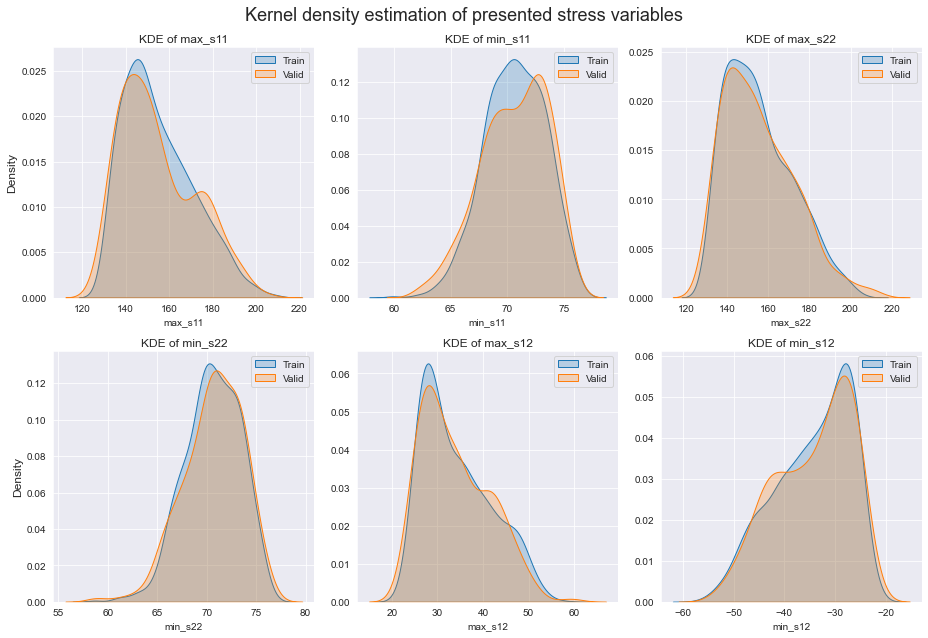

In [8]:
kde_plot([df_train, df_valid],
         ['max_s11', 'min_s11','max_s22', 'min_s22','max_s12', 'min_s12'],
         'stress')

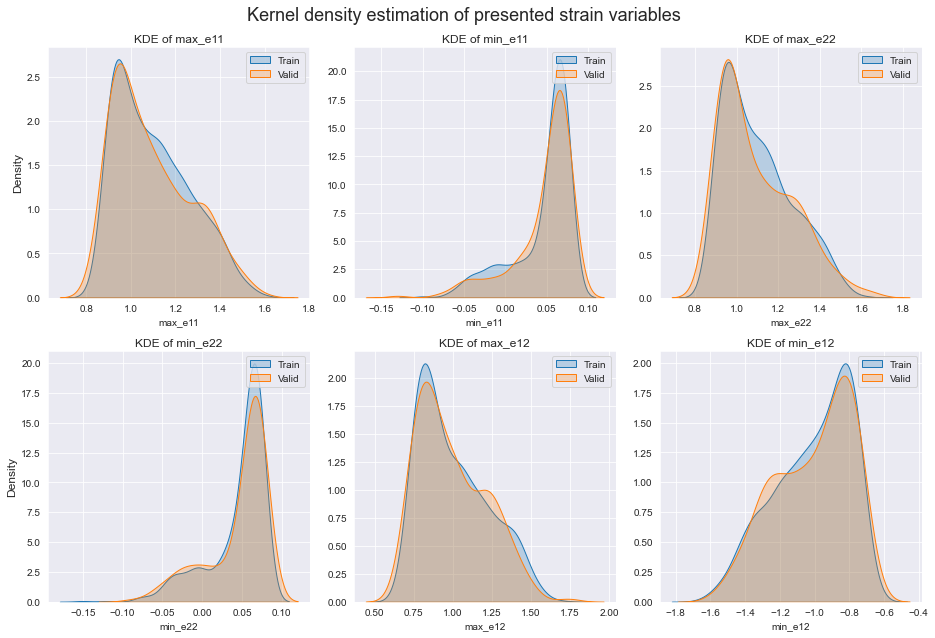

In [9]:
kde_plot([df_train, df_valid],
         ['max_e11', 'min_e11','max_e22', 'min_e22','max_e12', 'min_e12'],
         'strain')

Распределения всех представленных величин крайне схожи по своей форме для различных наборов данных - тренировочного, валидационного и тестового датасетов.

## Загрузчик данных

Напишем загрузчик данных, который сможет выгружать датасеты по отдельным компонентам.

In [10]:
class Stress_dataset(torch.utils.data.Dataset):
    
    def __init__(self, df, component, transform=None):
        
        columns_mask = [component in column for column in df.columns]
        columns_mask[-1] = True
        columns = df.columns[columns_mask]
        
        self.df = df[columns]
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        #geometry preprocessing
        geometry = cv2.imread(self.df.iloc[index, -1], cv2.IMREAD_GRAYSCALE)
        #crop
        geometry = geometry[20:780, 331:1092]
        #resize
        geometry = cv2.resize(geometry, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normalize
        #geometry = (255 - geometry)
        geometry = cv2.threshold(geometry, 127, 255, cv2.THRESH_BINARY)[1]
        geometry = geometry / 255
        #add additional dimension
        geometry = np.array([geometry]).astype('float32')
          
        result = cv2.imread(self.df.iloc[index, -2], cv2.IMREAD_GRAYSCALE)
        #crop
        result = result[118:637, 523:1043]
        #resize image
        result = cv2.resize(result, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normolize between 0 and 1
        result = result / 255
        
        #normalize between min and max stresses
        result = cv2.normalize(
            result, None, alpha=self.df.iloc[index, 1], beta=self.df.iloc[index, 0], norm_type=cv2.NORM_MINMAX
        )
        result = np.array([result]).astype('float32') #* 100
        
        #augmentation
        if self.transform is not None:
            aug = self.transform(image=result, mask=geometry)
            result = aug['image']
            geometry = aug['mask']
        
        #convert to torch.Tensor
        geometry = torch.from_numpy(geometry.copy()).type(torch.float32)
        result = torch.from_numpy(result.copy()).type(torch.float32)
        
        return (geometry, result)

In [11]:
train_transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1)
])

Начнем работу с компоненты тензора напряжений - $\bf{\sigma_{11}}$.

In [12]:
train_dataset = Stress_dataset(df_train, CURRENT_ELEMENT, transform=train_transform)
valid_dataset = Stress_dataset(df_valid, CURRENT_ELEMENT)

In [13]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
def image_show_tensor(dataloader, number_of_images=3, initial_index=0, values_name=None):
    
    masks, images = next(iter(dataloader))

    fig = plt.figure(figsize=(20, 20))
    
    for idx, tensor in enumerate([masks, images]):
        
        tensor = tensor.numpy().transpose(0,2,3,1)
        
        fig = plt.figure(figsize=(20, 20))
        
        for i in range(number_of_images):

            fig.add_subplot(1, number_of_images+1, i+1)
            
            if idx == 0:
                plt.imshow(tensor[i+initial_index], cmap='PuBu')
            else:
                plt.imshow(tensor[i+initial_index], cmap='viridis_r')
            
            min = (tensor[i+initial_index]).min()
            max = (tensor[i+initial_index]).max()

            plt.clim(min, max)
            plt.colorbar(shrink=0.2015)
            
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            
            if values_name == None:
                plt.title(f'Min={min} Max={max}')
            else:
                plt.title(f'{values_name} Min={min:.2f} Max={max:.2f}')

<Figure size 1440x1440 with 0 Axes>

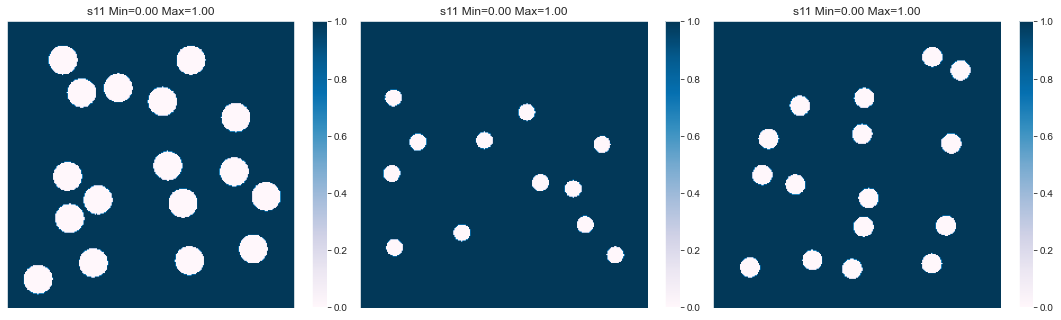

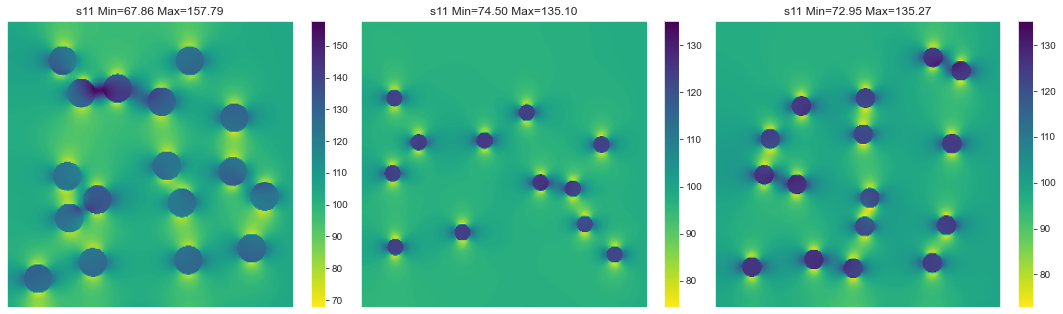

In [15]:
image_show_tensor(train_dataloader, values_name=CURRENT_ELEMENT)

## Модель 

Определим **дискриминатор**.

In [16]:
class Discriminator(nn.Module):
    """Discriminator Network"""
    def __init__(self):
        super(Discriminator, self).__init__()

        self.in_channels = 1
        self.ndf = 64
        self.out_channels = 1

        self.main = nn.Sequential(
            nn.Conv2d(self.in_channels * 2, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 128

            nn.Conv2d(self.ndf, self.ndf*2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*2),
            # 64 x 64

            nn.Conv2d(self.ndf*2, self.ndf*4, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*4),
            # 32 x 32

            nn.Conv2d(self.ndf*4, self.ndf*8, 4, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ndf*8),
            # 31 x 31

            nn.Conv2d(self.ndf*8, self.out_channels, 4, 1, 1, bias=False),
            # 30 x 30 (PatchGAN)
            nn.Sigmoid()
        )

    def forward(self, x, label):
        
        out = torch.cat((x, label), dim=1)
        out = self.main(out)
        
        return out

И **генератор**.

In [17]:
class Generator(nn.Module):
    """Generator Network"""
    def __init__(self):
        super(Generator, self).__init__()

        self.input_dim = 1
        self.ngf = 64
        self.output_dim = 1

        self.conv1 = nn.Sequential(
            nn.Conv2d(self.input_dim, self.ngf, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.ngf, self.ngf*2, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(self.ngf*2, self.ngf*4, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*4)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(self.ngf*4, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv6 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.InstanceNorm2d(self.ngf*8)
        )

        self.conv8 = nn.Sequential(
            nn.Conv2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.deconv1 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*8, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv2 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv3 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv4 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*8, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*8),
            nn.ReLU(inplace=True)
        )

        self.deconv5 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*16, self.ngf*4, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*4),
            nn.ReLU(inplace=True)
        )

        self.deconv6 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*8, self.ngf*2, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf*2),
            nn.ReLU(inplace=True)
        )

        self.deconv7 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*4, self.ngf, 4, 2, 1),
            nn.InstanceNorm2d(self.ngf),
            nn.ReLU(inplace=True)
        )

        self.deconv8 = nn.Sequential(
            nn.ConvTranspose2d(self.ngf*2, self.output_dim, 4, 2, 1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)

        dec1 = torch.cat([self.deconv1(enc8), enc7], dim=1)
        dec2 = torch.cat([self.deconv2(dec1), enc6], dim=1)
        dec3 = torch.cat([self.deconv3(dec2), enc5], dim=1)
        dec4 = torch.cat([self.deconv4(dec3), enc4], dim=1)
        dec5 = torch.cat([self.deconv5(dec4), enc3], dim=1)
        dec6 = torch.cat([self.deconv6(dec5), enc2], dim=1)
        dec7 = torch.cat([self.deconv7(dec6), enc1], dim=1)
        out = self.deconv8(dec7)

        return out

In [18]:
def set_requires_grad(network, requires_grad=False):
    """Prevent a Network from Updating"""
    for param in network.parameters():
        param.requires_grad = requires_grad

In [19]:
D = Discriminator().to(device)
G = Generator().to(device)

Обозначим дополнительные метрики оценки качества работы генератора:

In [20]:
mean_absolute_error = MeanAbsoluteError()
mean_squared_error = MeanSquaredError()

Определим **loss**-функцию и **optimizer**.

In [21]:
criterion_Adversarial = nn.BCELoss()
criterion_Pixelwise = nn.L1Loss()

In [22]:
D_optim = torch.optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
G_optim = torch.optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

## Обучение

In [23]:
G_train_loss_history, G_valid_loss_history = [], []
D_train_loss_history, D_valid_loss_history = [], []

mae_train_loss_history, mae_valid_loss_history = [], []
mse_train_loss_history, mse_valid_loss_history = [], []

for epoch in range(EPOCH):
    
    G_train_batch_loss_history, G_valid_batch_loss_history = [], []
    D_train_batch_loss_history, D_valid_batch_loss_history = [], []
    
    mae_train_batch_loss_history, mae_valid_batch_loss_history = [], []
    mse_train_batch_loss_history, mse_valid_batch_loss_history = [], []
    
    #train
    for geometry, result in train_dataloader:
        
        D_optim.zero_grad()
        G_optim.zero_grad()
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        set_requires_grad(D, requires_grad=False)
        
        #Train Generator
        fake_result = G(geometry)
        prob_fake = D(fake_result, geometry)
        real_labels = torch.ones(prob_fake.size()).to(device)
        
        G_loss_fake = criterion_Adversarial(prob_fake, real_labels)
        G_loss_pixelwise = criterion_Pixelwise(fake_result, result)
        G_loss = G_loss_fake +  LAMBDA_L1 * G_loss_pixelwise
        mae_train = mean_absolute_error(fake_result.cpu(), result.cpu())
        mse_train = mean_squared_error(fake_result.cpu(), result.cpu())
        
        mae_train_batch_loss_history.append(mae_train.item())
        mse_train_batch_loss_history.append(mse_train.item())
        G_train_batch_loss_history.append(G_loss.item())
        
        G_loss.backward()
        G_optim.step()
        
        #Train Discriminator
        set_requires_grad(D, requires_grad=True)
        
        prob_real = D(result, geometry)
        real_labels = torch.ones(prob_real.size()).to(device)
        D_real_loss = criterion_Adversarial(prob_real, real_labels)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result.detach(), geometry)
        fake_labels = torch.zeros(prob_fake.size()).to(device)
        
        D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)
        D_loss = torch.mean(D_real_loss + D_fake_loss)
        D_train_batch_loss_history.append(D_loss.item())
        
        D_loss.backward()
        D_optim.step()
        
        del geometry, result, fake_labels, real_labels
        torch.cuda.empty_cache()
        
    #valid    
    for geometry, result in valid_dataloader:
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result, geometry)
        real_labels = torch.ones(prob_fake.size()).to(device)
        
        G_loss_fake = criterion_Adversarial(prob_fake, real_labels)
        G_loss_pixelwise = criterion_Pixelwise(fake_result, result)
        G_loss = G_loss_fake + LAMBDA_L1 * G_loss_pixelwise
        mae_valid = mean_absolute_error(fake_result.cpu(), result.cpu())
        mse_valid = mean_squared_error(fake_result.cpu(), result.cpu())
        
        mae_valid_batch_loss_history.append(mae_valid.item())
        mse_valid_batch_loss_history.append(mse_valid.item())
        G_valid_batch_loss_history.append(G_loss.item())
        
        prob_real = D(result, geometry)
        real_labels = torch.ones(prob_real.size()).to(device)
        D_real_loss = criterion_Adversarial(prob_real, real_labels)
        
        fake_result = G(geometry)
        prob_fake = D(fake_result.detach(), geometry)
        fake_labels = torch.zeros(prob_fake.size()).to(device)
        
        D_fake_loss = criterion_Adversarial(prob_fake, fake_labels)
        D_loss = torch.mean(D_real_loss + D_fake_loss)
        D_valid_batch_loss_history.append(D_loss.item())
        
        del geometry, result, fake_labels, real_labels
        torch.cuda.empty_cache()
    
    mae_train_loss = np.mean(mae_train_batch_loss_history)
    mae_train_loss_history.append(mae_train_loss)
    mse_train_loss = np.mean(mse_train_batch_loss_history)
    mse_train_loss_history.append(mse_train_loss)
    G_train_loss = np.mean(G_train_batch_loss_history)
    G_train_loss_history.append(G_train_loss)
    D_train_loss = np.mean(D_train_batch_loss_history)
    D_train_loss_history.append(D_train_loss)
    
    mae_valid_loss = np.mean(mae_valid_batch_loss_history)
    mae_valid_loss_history.append(mae_valid_loss)
    mse_valid_loss = np.mean(mse_valid_batch_loss_history)
    mse_valid_loss_history.append(mse_valid_loss)
    G_valid_loss = np.mean(G_valid_batch_loss_history)
    G_valid_loss_history.append(G_valid_loss)
    D_valid_loss = np.mean(D_valid_batch_loss_history)
    D_valid_loss_history.append(D_valid_loss)
    
    del G_train_batch_loss_history, D_train_batch_loss_history, G_valid_batch_loss_history, D_valid_batch_loss_history

    print(
        f'{epoch} | D:{D_train_loss:.4f} | G:{G_train_loss:.4f} | D Valid:{D_valid_loss:.4f} | G Valid:{G_valid_loss:.4f} | MAE:{mae_train_loss:.2f} | MSE:{mse_train_loss:.2f} | MAE Valid:{mae_valid_loss:.2f} | MSE Valid:{mse_valid_loss:.2f}'
    )

0 | D:0.3273 | G:4654.4068 | D Valid:0.0064 | G Valid:619.7747 | MAE:46.50 | MSE:3723.39 | MAE Valid:6.13 | MSE Valid:151.69
1 | D:0.1566 | G:504.9511 | D Valid:0.0031 | G Valid:440.7856 | MAE:4.99 | MSE:97.14 | MAE Valid:4.34 | MSE Valid:65.81
2 | D:0.0018 | G:389.8192 | D Valid:0.0013 | G Valid:412.9524 | MAE:3.82 | MSE:48.11 | MAE Valid:4.05 | MSE Valid:42.26
3 | D:0.5151 | G:321.1793 | D Valid:0.0136 | G Valid:315.5143 | MAE:3.16 | MSE:28.03 | MAE Valid:3.10 | MSE Valid:23.29
4 | D:1.0169 | G:280.6050 | D Valid:0.7805 | G Valid:332.8866 | MAE:2.78 | MSE:20.24 | MAE Valid:3.31 | MSE Valid:24.61
5 | D:0.8913 | G:263.7305 | D Valid:0.5007 | G Valid:283.2520 | MAE:2.62 | MSE:16.55 | MAE Valid:2.81 | MSE Valid:16.55
6 | D:0.3924 | G:253.7743 | D Valid:0.0212 | G Valid:266.1086 | MAE:2.50 | MSE:14.74 | MAE Valid:2.61 | MSE Valid:16.73
7 | D:0.2586 | G:251.6794 | D Valid:0.0165 | G Valid:283.4636 | MAE:2.47 | MSE:13.76 | MAE Valid:2.78 | MSE Valid:17.29
8 | D:0.5673 | G:239.4603 | D Valid

69 | D:0.4283 | G:79.5878 | D Valid:0.4106 | G Valid:221.7774 | MAE:0.75 | MSE:2.54 | MAE Valid:2.18 | MSE Valid:8.88
70 | D:0.4493 | G:78.1992 | D Valid:0.2619 | G Valid:218.6837 | MAE:0.74 | MSE:2.46 | MAE Valid:2.16 | MSE Valid:8.72
71 | D:0.4829 | G:76.1782 | D Valid:0.5879 | G Valid:214.5389 | MAE:0.72 | MSE:2.41 | MAE Valid:2.09 | MSE Valid:8.23
72 | D:0.4801 | G:76.1594 | D Valid:0.7380 | G Valid:218.7950 | MAE:0.72 | MSE:2.41 | MAE Valid:2.14 | MSE Valid:8.47
73 | D:0.4603 | G:76.0405 | D Valid:0.2990 | G Valid:229.3516 | MAE:0.72 | MSE:2.37 | MAE Valid:2.25 | MSE Valid:9.08
74 | D:0.5069 | G:78.2036 | D Valid:0.9088 | G Valid:218.2887 | MAE:0.74 | MSE:2.44 | MAE Valid:2.13 | MSE Valid:8.52
75 | D:0.5194 | G:76.1494 | D Valid:1.1301 | G Valid:228.1565 | MAE:0.72 | MSE:2.36 | MAE Valid:2.22 | MSE Valid:9.08
76 | D:0.5163 | G:72.6112 | D Valid:0.3200 | G Valid:220.9061 | MAE:0.69 | MSE:2.31 | MAE Valid:2.18 | MSE Valid:8.91
77 | D:0.5197 | G:73.5175 | D Valid:0.4893 | G Valid:217

139 | D:0.2536 | G:64.5575 | D Valid:0.8516 | G Valid:219.0341 | MAE:0.59 | MSE:2.25 | MAE Valid:2.14 | MSE Valid:8.70
140 | D:0.2632 | G:65.5586 | D Valid:0.4784 | G Valid:217.6360 | MAE:0.60 | MSE:2.29 | MAE Valid:2.14 | MSE Valid:8.66
141 | D:0.4276 | G:64.4366 | D Valid:0.4975 | G Valid:219.3626 | MAE:0.59 | MSE:2.19 | MAE Valid:2.15 | MSE Valid:8.77
142 | D:0.2547 | G:64.5207 | D Valid:1.2978 | G Valid:221.6565 | MAE:0.59 | MSE:2.25 | MAE Valid:2.16 | MSE Valid:8.81
143 | D:0.2045 | G:64.9371 | D Valid:1.1658 | G Valid:225.2003 | MAE:0.59 | MSE:2.27 | MAE Valid:2.19 | MSE Valid:9.08
144 | D:0.2493 | G:64.6902 | D Valid:2.3132 | G Valid:221.7616 | MAE:0.59 | MSE:2.23 | MAE Valid:2.13 | MSE Valid:8.67
145 | D:0.2502 | G:66.5077 | D Valid:1.4665 | G Valid:219.1983 | MAE:0.60 | MSE:2.20 | MAE Valid:2.14 | MSE Valid:8.68
146 | D:0.2807 | G:66.4327 | D Valid:0.7882 | G Valid:218.9470 | MAE:0.61 | MSE:2.22 | MAE Valid:2.14 | MSE Valid:8.74
147 | D:0.2874 | G:64.7543 | D Valid:0.3815 | G 

208 | D:0.1391 | G:62.9355 | D Valid:1.0512 | G Valid:220.6647 | MAE:0.56 | MSE:2.07 | MAE Valid:2.14 | MSE Valid:8.67
209 | D:0.1145 | G:63.3169 | D Valid:1.0480 | G Valid:223.0022 | MAE:0.56 | MSE:2.13 | MAE Valid:2.17 | MSE Valid:9.00
210 | D:0.3363 | G:63.3079 | D Valid:1.6929 | G Valid:224.5944 | MAE:0.56 | MSE:2.08 | MAE Valid:2.18 | MSE Valid:8.79
211 | D:0.2968 | G:61.4856 | D Valid:2.4781 | G Valid:225.9343 | MAE:0.55 | MSE:2.01 | MAE Valid:2.18 | MSE Valid:8.91
212 | D:0.1506 | G:62.7454 | D Valid:2.3462 | G Valid:227.4741 | MAE:0.55 | MSE:2.05 | MAE Valid:2.20 | MSE Valid:9.01
213 | D:0.1992 | G:62.7448 | D Valid:2.1782 | G Valid:224.0679 | MAE:0.55 | MSE:2.05 | MAE Valid:2.16 | MSE Valid:8.77
214 | D:0.2160 | G:61.8663 | D Valid:2.4487 | G Valid:224.2406 | MAE:0.55 | MSE:2.02 | MAE Valid:2.16 | MSE Valid:8.76
215 | D:0.2017 | G:62.8492 | D Valid:0.6826 | G Valid:220.0494 | MAE:0.55 | MSE:2.03 | MAE Valid:2.15 | MSE Valid:8.70
216 | D:0.1992 | G:62.8208 | D Valid:2.3170 | G 

277 | D:0.1946 | G:58.6000 | D Valid:2.0263 | G Valid:220.5813 | MAE:0.50 | MSE:1.93 | MAE Valid:2.12 | MSE Valid:8.52
278 | D:0.1969 | G:60.9299 | D Valid:3.6761 | G Valid:224.6705 | MAE:0.52 | MSE:1.93 | MAE Valid:2.14 | MSE Valid:8.68
279 | D:0.1792 | G:61.1242 | D Valid:1.8655 | G Valid:221.8913 | MAE:0.53 | MSE:1.93 | MAE Valid:2.14 | MSE Valid:8.71
280 | D:0.1259 | G:61.3927 | D Valid:3.6186 | G Valid:224.9051 | MAE:0.53 | MSE:1.99 | MAE Valid:2.13 | MSE Valid:8.73
281 | D:0.2140 | G:61.1528 | D Valid:1.8204 | G Valid:217.5022 | MAE:0.52 | MSE:1.97 | MAE Valid:2.12 | MSE Valid:8.53
282 | D:0.3841 | G:59.2984 | D Valid:4.4536 | G Valid:222.9002 | MAE:0.51 | MSE:1.90 | MAE Valid:2.13 | MSE Valid:8.51
283 | D:0.2307 | G:59.5862 | D Valid:1.0715 | G Valid:221.2884 | MAE:0.52 | MSE:1.91 | MAE Valid:2.14 | MSE Valid:8.78
284 | D:0.1131 | G:62.2189 | D Valid:2.4640 | G Valid:227.7741 | MAE:0.54 | MSE:2.01 | MAE Valid:2.16 | MSE Valid:8.79
285 | D:0.1186 | G:61.6278 | D Valid:1.5453 | G 

Сохраним полученную модель генератора.

In [24]:
torch.save(G, path_model_save + CURRENT_ELEMENT)

## Результаты 

Отдельно сохраним результаты обучения модели.

In [25]:
dict_data = {'G train loss' : G_train_loss_history,
             'G valid loss' : G_valid_loss_history,
             'D train loss' : D_train_loss_history,
             'D valid loss' : D_valid_loss_history,
             'MAE Train' : mae_train_loss_history,
             'MSE Train' : mse_train_loss_history,
             'MAE Valid' : mae_valid_loss_history,
             'MSE Valid' : mse_valid_loss_history}

In [26]:
df_results = pd.DataFrame.from_dict(dict_data)
df_results.to_csv('S:/abaqus_job_files/results_data/loss_results_' + CURRENT_ELEMENT + '.csv', sep=' ')

In [27]:
def loss_plot(data):
    
    generator_loss_names = data.columns[:2]
    discriminator_loss_names = data.columns[2:]
    legend_names = ['Train', 'Valid']
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, j, k in zip(generator_loss_names, discriminator_loss_names, legend_names):
        
        ax[0].plot(data[i].values, label=k)
        ax[1].plot(data[j].values, label=k)
        
    for i, j in enumerate(['Generator', 'Discriminator']):

        ax[i].set_title(f'{j} Loss Plot', fontsize=14)
        ax[i].set_xlabel('Iteration', fontsize=12)
        ax[i].set_ylabel(f'{j} Loss Function Value', fontsize=12)
        ax[i].legend()
        
    fig.suptitle('Loss functions plot for $\sigma_{11}$', fontsize=18)
    plt.show()

Визуализируем значения функции потерь для каждого из датасетов.

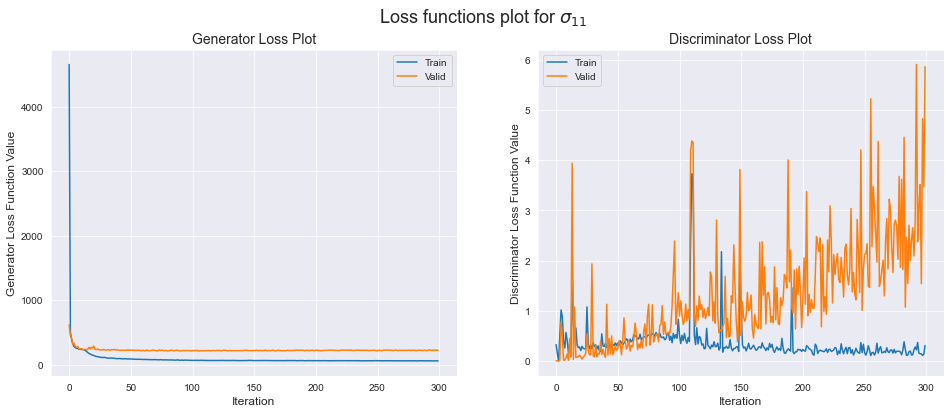

In [28]:
loss_plot(df_results)

Визуально оценим результаты работы алгоритма.

In [29]:
def singular_result(dataloader, model=G, initial_index=0, cmap='viridis', component='$\sigma_{11}$'):
    
    model.eval()
    model = model.cpu()
    geometry, result = next(iter(dataloader))

    prediction = model(geometry.float())
    error = abs(result - prediction)

    tensors = [geometry, result, prediction, error]
    titles = ['Geometry', f'True {component} field', f'Predicted {component} field', '$L_{1}$ error']
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    for tensor, title, i, j in zip(tensors, titles, [0, 0, 1, 1], [0, 1, 0, 1]): 
        
        tensor = tensor.cpu().detach().numpy().transpose(0,2,3,1)
        
        if i == 0 and j == 0:
            img = ax[i, j].imshow(tensor[initial_index], cmap='PuBu')
        elif i != j:
            img = ax[i, j].imshow(tensor[initial_index], cmap=cmap)
        else:
            img = ax[i, j].imshow(tensor[initial_index], cmap='icefire')
            
        ax[i, j].set_title(title, fontsize=14)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        min = (tensor[initial_index]).min()
        max = (tensor[initial_index]).max()
        
        if i == 1 and j == 1:
            img.set_clim(0, max)
        else:
            img.set_clim(min, max)
            
        plt.colorbar(img, shrink=0.815, ax=ax[i, j])
            
    fig.suptitle(f'Visualization for the one sample of {component}', fontsize=18)
    fig.tight_layout()
    plt.show()

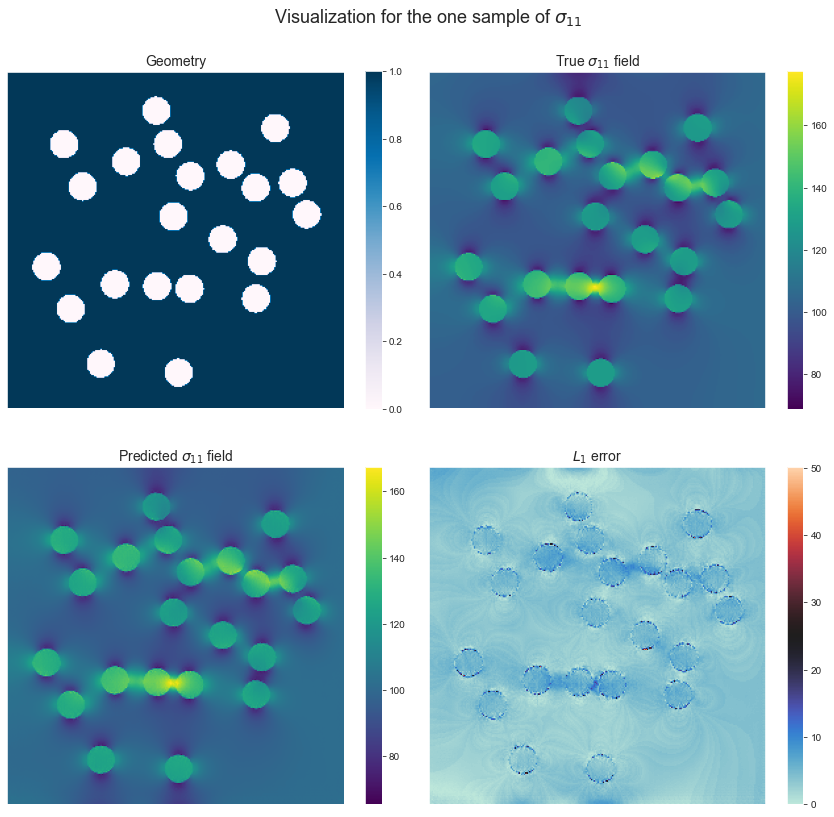

In [30]:
singular_result(valid_dataloader)